In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset
from torchvision.models import vgg16, vit_b_16, ViT_B_16_Weights

from torchvision import transforms
import torch.nn as nn
import torch

from PIL import Image

import os

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

from math import log10, sqrt 
from skimage.metrics import structural_similarity as ssim
import cv2

import time

In [2]:
vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

# for p in vit.parameters():
#     p.requires_grad = False

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 146MB/s]  


In [3]:
def create_df(base_dir):
    dd = {"sharp": [], "motion_blurred": []}
    images = []
    sharps = os.path.join(base_dir, "sharp")
    blurrs = os.path.join(base_dir, "motion_blurred")
    for i in os.listdir(sharps):
        index = i.lower().find("s.jp")
        sharp = os.path.join(sharps, i)
        blurr_img = i[:index] + 'M' + i[index+1:]
        blurr = os.path.join(blurrs, blurr_img)
        dd["sharp"] += [sharp]
        dd["motion_blurred"] += [blurr]
    return pd.DataFrame(dd)

In [4]:
base_dir = "/kaggle/input/blur-dataset"

In [5]:
df = create_df(base_dir)

In [6]:
class DS(nn.Module):
    def __init__(self, data, transform, patch_transform):
        super(DS, self).__init__()
        self.data = data
        self.transform = transform
        self.patch_transform = patch_transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        data, target = self.data[x, 1], self.data[x, 0]
        data = Image.open(data).convert("RGB")
        target = Image.open(target).convert("RGB")
        data = np.array(data)
        img = self.transform(data)
        patch = self.patch_transform(data)
        target = self.transform(np.array(target))
        return img, target, patch

In [7]:
EPOCHS = 100
LR = 0.1
GAMMA = 0.1
STEP = 25
IMG_SIZE = 224
IMAGE_CHANNELS = 3
BATCH = 1
OUTPUT_FTRS = vit.heads.head.out_features
SEQUENCE = 588

In [8]:
num_ftrs = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_ftrs, SEQUENCE)

In [9]:
in_transforms = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                   transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])
patch_size = 14
patch_transforms = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                   transforms.Resize((patch_size, patch_size)),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])

In [10]:
train, validate = train_test_split(df.values, random_state=42, test_size=0.2)
val, test = train_test_split(validate, random_state=42, test_size=0.5)

In [11]:
train_ds = DS(train, in_transforms, patch_transforms)
val_ds = DS(val, in_transforms, patch_transforms)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [12]:
class DecoderBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=channels,
                              out_channels=channels,
                              kernel_size=1)
        self.gelu = nn.GELU(approximate='none')
        
    def forward(self, x):
        return self.gelu(self.conv(x))
    

class ViTDeblur(nn.Module):
    def __init__(self, backbone,
                 output_ftrs,
                 sequence,
                 channels,
                 img_size,
                 batch_size,
                 decoder_layers=3):
        super().__init__()
        self.model = backbone
        self.batch = batch_size
        self.img = img_size
        self.channels = channels
        self.sequence = sequence
        self.upscale = [nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=1) for _ in range(5)]
        if torch.cuda.is_available():
            for i in range(len(self.upscale)):
                self.upscale[i] = self.upscale[i].cuda()
        self.decoder = nn.Sequential(*[DecoderBlock(channels) for _ in range(decoder_layers)])
        self.conv = nn.Conv2d(in_channels=channels,
                              out_channels=channels,
                              kernel_size=1)
        
    def forward(self, x, img, patch):
        x = self.model(x)
        size = int((self.sequence//self.channels)**(0.5))
        x = x.view([x.shape[0], self.channels, size, size])
        x = torch.add(x, patch)
        x = self.upscale[0](x)
        for i in range(4):
            x = nn.functional.interpolate(x, size=[x.shape[2]*2, x.shape[2]*2])
            x = self.upscale[i+1](x)
        x = torch.add(x, img)
        x = self.decoder(x)
        x = torch.add(x, img)
        x = self.conv(x)
        
        return x

In [13]:
def ContentLoss(x, target):
    out = nn.functional.mse_loss(x, target)
    return out

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
vit = vit.to(device)
model = ViTDeblur(vit, OUTPUT_FTRS, SEQUENCE, 
                   IMAGE_CHANNELS, IMG_SIZE, BATCH, 5)
model = model.to(device)
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [16]:
best_model = deepcopy(model)
best_val = -1

train_loss = []
val_loss = []
epoch_time = []

for i in range(1, EPOCHS+1):
    start = time.time()
    model.train()
    
    diff = 0
    total = 0
    
    for data, target, patches in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target, patches = data.cuda(), target.cuda(), patches.cuda()
        out = model(data, data, patches)
        loss = criterion(out, target)
        diff += loss.item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    
    model.eval()
    diff = 0
    total = 0
    with torch.no_grad():
        for data, target, patches in val_dl:
            if torch.cuda.is_available():
                data, target, patches = data.cuda(), target.cuda(), patches.cuda()
            out = model(data, data, patches)
            loss = criterion(out, target)
            diff += loss.item()
            total += out.size(0)
            
    val_loss += [diff/total]
    if best_val == -1 or val_loss[-1] < best_val:
        best_val = val_loss[-1]
        best_model = deepcopy(model)
        
#     print("Epochs {} train loss {} val loss {}".format(i, train_loss[-1], val_loss[-1]))
    if i%10 == 0 or i == 1:
        print("Epochs {} train loss {} val loss {}".format(i, train_loss[-1], val_loss[-1]))
    scheduler.step()
    end = time.time()
    fin = end - start
    epoch_time += [fin]

Epochs 1 train loss 0.9255925950195109 val loss 1.0147212667124612
Epochs 10 train loss 0.9169600901326963 val loss 1.0606631210872106
Epochs 20 train loss 0.916790051598634 val loss 1.009409669467381
Epochs 30 train loss 0.8938816487789154 val loss 0.9973993080002921
Epochs 40 train loss 0.8938934911042452 val loss 1.0022024137633188
Epochs 50 train loss 0.8931809975100415 val loss 0.9971536202090127
Epochs 60 train loss 0.891496932346906 val loss 0.9967295553003038
Epochs 70 train loss 0.8914771856474025 val loss 0.9972449541091919
Epochs 80 train loss 0.8912030022591353 val loss 0.9965124368667603
Epochs 90 train loss 0.8912016725433725 val loss 0.9966228944914681
Epochs 100 train loss 0.8912018106452056 val loss 0.9966705816132682


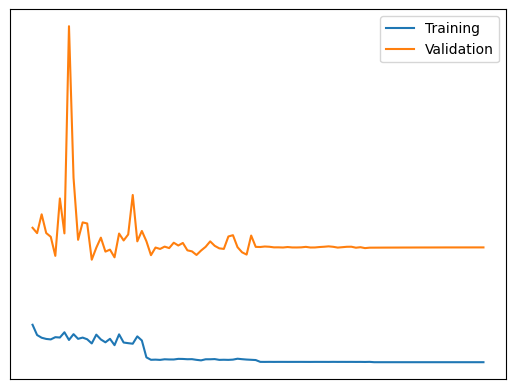

In [17]:
fig, axes = plt.subplots()
epochs = list(range(1, EPOCHS+1))
axes.plot(epochs, train_loss)
axes.plot(epochs, val_loss)
axes.legend(["Training", "Validation"])
plt.xticks(())
plt.yticks(())
plt.show()

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
print("Best model params: ")
print(count_parameters(best_model))

print("Model params: ")
print(count_parameters(model))

Best model params: 
86250900
Model params: 
86250900


In [20]:
def predict(image):
    image = np.array(Image.open(image).convert("RGB"))
    blurred = in_transforms(image).view([1, 3, 224, 224])
    patched = patch_transforms(image).view([1, 3, patch_size, patch_size])
    model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            blurred, patched = blurred.cuda(), patched.cuda()
        check_img = model(blurred, blurred, patched)
    return check_img.permute(0, 2, 3, 1).cpu().detach().numpy()[0]

In [21]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [22]:
def SSIM(original, pred):
    before_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    after_gray = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
    (score, diff) = ssim(before_gray, after_gray, full=True, data_range=255.0)
    return score

In [23]:
predicted = []
truth = []
psnr_scores = []
ssim_scores = []
avg_time = []
for i in range(test.shape[0]):
    blurred_image = test[i, 1]
    start = time.time()
    result = predict(blurred_image)
    end = time.time()
    avg_time += [end-start]
    ground_truth = np.array(Image.open(test[i, 0]))
    ground_truth = in_transforms(ground_truth)
    ground_truth = ground_truth.permute(1, 2, 0).detach().numpy()
    psnr_scores += [PSNR(ground_truth, result)]
    ssim_scores += [SSIM(ground_truth, result)]
    predicted += [result]
    truth += [ground_truth]

In [24]:
print("Mean PSNR: ", np.mean(psnr_scores))
print("Mean SSIM: ", np.mean(ssim_scores))
print("Average time required to converge: ", np.mean(avg_time))

Mean PSNR:  48.74645764679415
Mean SSIM:  0.9136228544524212
Average time required to converge:  0.14943911007472446


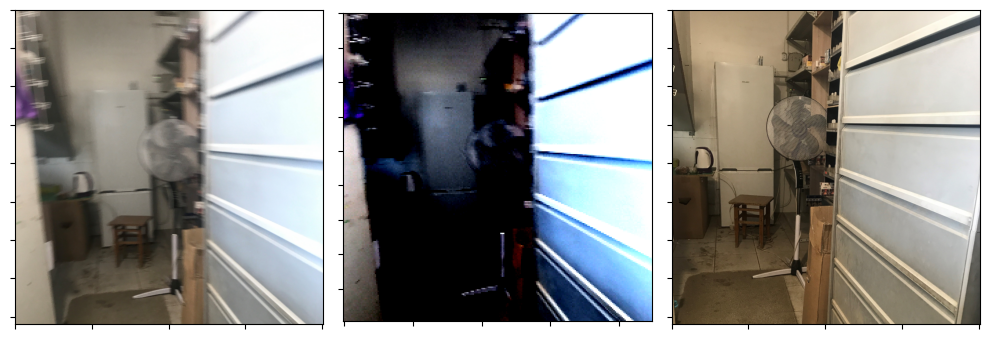

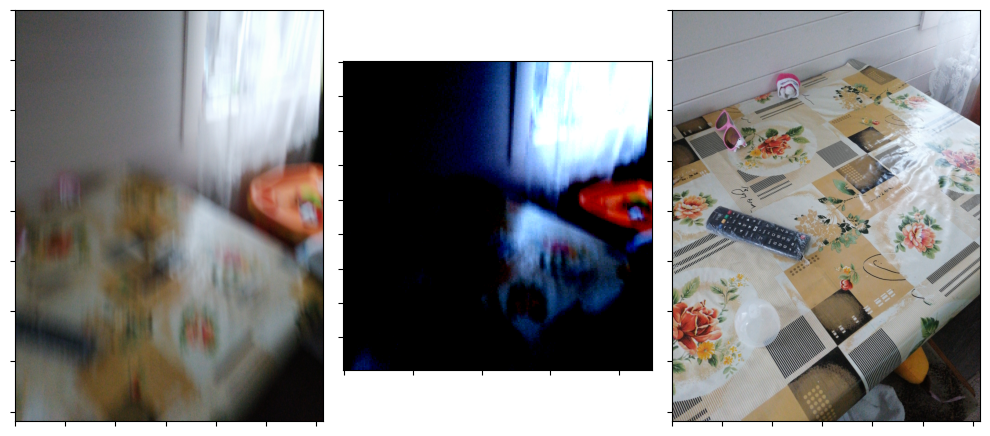

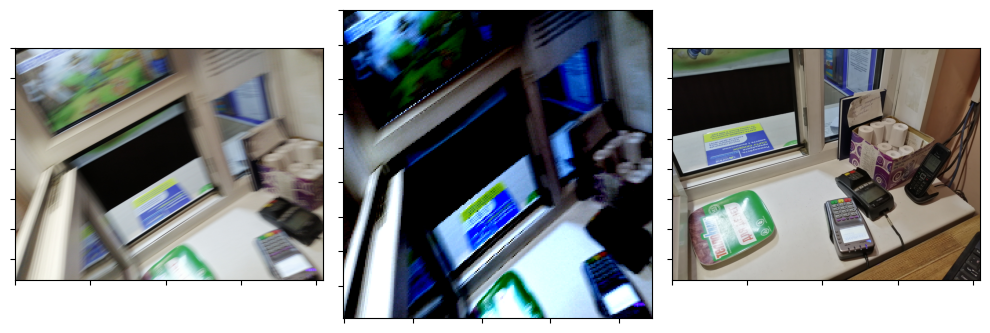

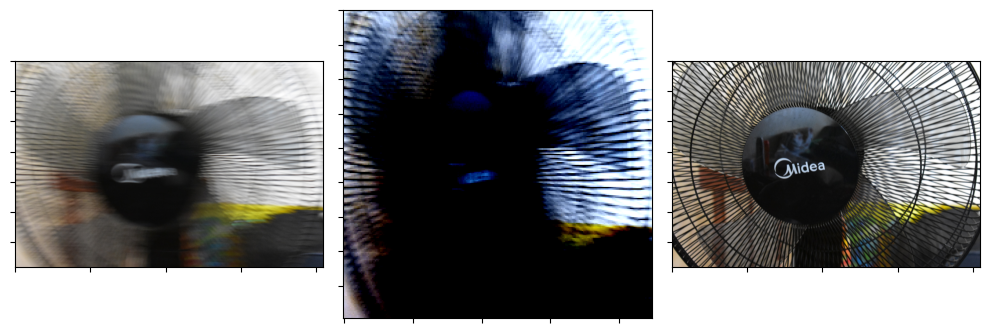

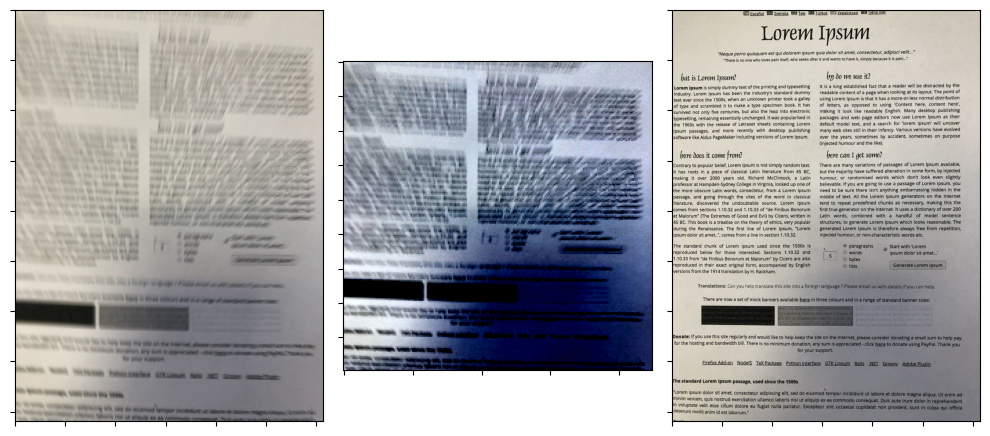

In [25]:
for i in range(5):
    prediction = predicted[i]
    blured = np.array(Image.open(test[i, 1]))
    truth = np.array(Image.open(test[i, 0]))

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 7))
    axes[0].imshow(blured)
    axes[1].imshow(prediction)
    axes[2].imshow(truth)
    axes[0].set_xticklabels(())
    axes[0].set_yticklabels(())
    
    axes[1].set_xticklabels(())
    axes[1].set_yticklabels(())
    
    axes[2].set_xticklabels(())
    axes[2].set_yticklabels(())
    plt.tight_layout()
    plt.show()

In [26]:
# torch.save(model.state_dict(), "/kaggle/working/deblurvit_l1_1.pt")